In [4]:
%matplotlib inline
import numpy as np
from openseespy.opensees import *
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import openseespy.postprocessing.Get_Rendering as opsplt
import ops_vis2 as opsv2
import handcalcs.render

# Enunciado

1. Realizar el análisis sísmico estático (4 puntos)
2. Incluir aportes de normas internacionales al análisis sísmico estático (4 puntos)
3. Realizar el análisis sísmico modal espectral (4 puntos)
4. Realizar el análisis sísmico tiempo-historia, incluyendo el escalamiento al espectro de diseño  (4 puntos)
5. Realizar el análisis comparativo y discusión de resultados (4 puntos)

In [5]:
# Unidades Base
m = 1
kg = 1
s = 1

# Otras Unidades
cm = 0.01*m
N = kg*m/s**2
kN = 1000*N
kgf = 9.80665*N
tonf = 1000*kgf
Pa = N/m**2

# Constantes Físicas
g = 9.80665*m/s**2

# Propiedades de los Materiales

In [6]:
fc = 210*kg/cm**2
E = 151*fc**0.5*kgf/cm**2
G = 0.5*E/(1+0.2)

# Densidad del concreto
ρ = 2400*kg/m**3

# Pre Dimensionado

In [7]:
%%render
#Dimensiones de la estructura

#Espaciado Ejes
dx=5.5*m #m
dy=5.5*m #m
dz=2.4*m #m

#Cantidad Ejes
nx=4
ny=4
nz=4 #se esta considerando la base tambien pisos+base
nnz=nz-1

#Capacidad Portante
q_a=4*kgf/cm**2    #N/m^2

<IPython.core.display.Latex object>

In [8]:
%%render
#Pre dimensionado de las vigas
peralteX=dx/11 #m
anchoX=peralteX/2 #m

peralteY=dy/11 #m
anchoY=peralteY/2 #m

<IPython.core.display.Latex object>

In [9]:
#Pre dimensionado de la losa
if(dx>dy):
    peralteLosa=dx/25
else:
    peralteLosa=dy/25

In [10]:
%%render
peralteLosa #m

<IPython.core.display.Latex object>

In [11]:
%%render
#Pre dimensionado de Columna
Tributaria_Centrica=dx*dy  #m^2
Tributaria_Excentrica=dx*dy*0.5 #m^2
Tributaria_Esquinas=dx*dy*0.25 #m^2

Peso=1250*kgf/m**2  #N/m^2
Area_Centrica=(Peso*nnz*Tributaria_Centrica)/(0.45*fc)  #m^2
Area_Excentrica=(Peso*nnz*Tributaria_Centrica)/(0.35*fc)  #m^2
Area_Esquinas=(Peso*nnz*Tributaria_Centrica)/(0.35*fc)  #m^2

<IPython.core.display.Latex object>

In [12]:
%%render
#Pre dimensionado de Zapatas
Area_zapata=(Peso*nnz*Tributaria_Centrica)/(0.9*q_a) #m^2

<IPython.core.display.Latex object>

# MODELADO CONVENCIONAL

# Propuesta de Secciones:

In [13]:
#Columnas
l1 = 0.55*m
l2=0.55*m

#Vigas
b = 0.25*m
h=0.50*m

#Losa
h_l=0.25*m

#Zapata
l_z=1.8*m 

In [14]:
# Viga
Av = b*h
Izv = b*h**3/12
Iyv = b**3*h/12
aa, bb = max(b,h),min(b,h)
β= 1/3-0.21*bb/aa*(1-(bb/aa)**4/12)
Jxxv = β*bb**3*aa

# Columna
Ac = l1*l2
Izc = l1*l2**3/12
Iyc = l2*l1**3/12
β= 1/3-0.21*1.*(1-(1.)**4/12)
Jxxc = β*l1**4

# Metrado de Cargas

In [15]:
%%render
#Cargas de Area
# Aplicando Cargas vivas y muertas
wLive = 250*kgf/m**2 #N/m^2
wLosa = 300*kgf/m**2 #N/m^2
wAcab = 100*kgf/m**2 #N/m^2
wTabi = 150*kgf/m**2 #N/m^2

#Peso por Paño
wtotal = (1.0*(wLosa+wAcab+wTabi)+0.25*wLive)*dx*dy   #N
w=(wtotal/g)  #kg

#Cargas de Viga
Peso_Viga=b*h*ρ*g*nnz*((ny-1)*dx+(nx-1)*dy) #N

#Cargas de Columna
Peso_Columna=l1*l2*ρ*g*nnz*(ny*nx)*dz #N

#Cargas de Losa
Peso_Losa=wtotal*nnz*(nx-1)*(ny-1) #N

Peso_Sismico=Peso_Viga+Peso_Columna+Peso_Losa #N

<IPython.core.display.Latex object>

# Geometria

In [16]:
wipe()
model("basic","-ndm",3,"-ndf",6)

#Extrude
ele_shapes={}
ex=0
scala=1

#Masas Nodales
mm=0
pesoNodal=0
for i in range(nz):
    for j in range(ny):
        for k in range(nx):
            node(mm,dx*k,dy*j,dz*i)
            if i!=0:
                if (k==(nx-1) or k==0) and (j==(ny-1) or j==0):
                    mass(mm,w*0.25,w*0.25,0)
                    pesoNodal=pesoNodal+w*0.25
                else:
                    if k==(nx-1) or k==0 or j==(ny-1) or j==0:
                        mass(mm,w*0.5,w*0.5,0)
                        pesoNodal=pesoNodal+w*0.5
                    else:
                        mass(mm,w,w,0)
                        pesoNodal=pesoNodal+w
            mm=mm+1
print(pesoNodal)
Diaphram="ON"
diafragmas=[]
if Diaphram=="ON":
    dirDia=3
    for i in range(nz-1):
        aux_nodos=[]
        diafragmas.append(mm)
        node(mm,(dx*(nx-1))/2,(dy*(ny-1))/2,dz*(i+1))
        fix(mm,*[0,0,1,1,1,0])
        for j in range(ny*nx):
            aux_nodos.append(j+nx*ny*(i+1))
        rigidDiaphragm(dirDia,mm,*aux_nodos)
        mm=mm+1
    
else:
    print("No se esta usando diafragma rigido")

print(diafragmas)

500259.375
[64, 65, 66]


In [17]:
#Vigas
mw=0
geomTransf('Corotational', 1, *[1,-1, 0])
cod_vig=[]

for i in range(nz-1):
    #Vigas en X
    for j in range(ny):
        for k in range(nx-1):
            element("elasticBeamColumn",mw,nx*ny*(i+1)+k+j*nx,nx*ny*(i+1)+k+j*nx+1,Av,E,G,Jxxv,Iyv,Izv,1,"-mass",ρ*Av)
            mw=mw+1
            ele_shapes[ex]=["rect",[b*scala,h*scala]]
            ex=ex+1
    #Vigas en Y
    for k in range(nx):
        for j in range(ny-1):
            element("elasticBeamColumn",mw,nx*ny*(i+1)+k+nx*j,nx*ny*(i+1)+nx*(j+1)+k,Av,E,G,Jxxv,Iyv,Izv,1,"-mass",ρ*Av)
            mw=mw+1
            ele_shapes[ex]=["rect",[b*scala,h*scala]]
            ex=ex+1

nro_vig=mw
#Columnas
geomTransf('Corotational', 2, *[1, 0, 0])

for i in range(nz-1):
    for j in range(ny):
        for k in range(nx):
            element("elasticBeamColumn",mw, k+nx*j+nx*ny*(i),k+nx*j+nx*ny*(i+1) ,Ac,E,G,Jxxc,Iyc,Izc,2,"-mass",ρ*Ac)
            mw=mw+1
            ele_shapes[ex]=["rect",[l1*scala,l2*scala]]
            ex=ex+1

In [18]:
section('ElasticMembranePlateSection',1, E, 0.15, 0.50*m, ρ)

In [19]:
#Nodos del Soporte
node(67,-0.9,-0.9, 0.)
node(68,-0.9,0.0, 0.)
node(69,-0.9,0.9, 0.)
node(70,0.0,-0.9, 0.)
#node(71,0.0,0.0, 0.)
node(72,0.0,0.9, 0.)
node(73,0.9,-0.9, 0.)
node(74,0.9,0.0, 0.)
node(75,0.9,0.9, 0.)
 
node(76,4.6,-0.9, 0.)
node(77,4.6,0.0, 0.)
node(78,4.6,0.9, 0.)
node(79,5.5,-0.9, 0.)
#node(80,5.5,0.0, 0.)
node(81,5.5,0.9, 0.)
node(82,6.4,-0.9, 0.)
node(83,6.4,0.0, 0.)
node(84,6.4,0.9, 0.)
 
node(85,10.1,-0.9, 0.)
node(86,10.1,0.0, 0.)
node(87,10.1,0.9, 0.)
node(88,11.0,-0.9, 0.)
#node(89,11.0,0.0, 0.)
node(90,11.0,0.9, 0.)
node(91,11.9,-0.9, 0.)
node(92,11.9,0.0, 0.)
node(93,11.9,0.9, 0.)
 
node(94,15.6,-0.9, 0.)
node(95,15.6,0.0, 0.)
node(96,15.6,0.9, 0.)
node(97,16.5,-0.9, 0.)
#node(98,16.5,0.0, 0.)
node(99,16.5,0.9, 0.)
node(100,17.4,-0.9, 0.)
node(101,17.4,0.0, 0.)
node(102,17.4,0.9, 0.)
 
node(103,-0.9,4.6, 0.)
node(104,-0.9,5.5, 0.)
node(105,-0.9,6.4, 0.)
node(106,0.0,4.6, 0.)
#node(107,0.0,5.5, 0.)
node(108,0.0,6.4, 0.)
node(109,0.9,4.6, 0.)
node(110,0.9,5.5, 0.)
node(111,0.9,6.4, 0.)
 
node(112,4.6,4.6, 0.)
node(113,4.6,5.5, 0.)
node(114,4.6,6.4, 0.)
node(115,5.5,4.6, 0.)
#node(116,5.5,5.5, 0.)
node(117,5.5,6.4, 0.)
node(118,6.4,4.6, 0.)
node(119,6.4,5.5, 0.)
node(120,6.4,6.4, 0.)
 
node(121,10.1,4.6, 0.)
node(122,10.1,5.5, 0.)
node(123,10.1,6.4, 0.)
node(124,11.0,4.6, 0.)
#node(125,11.0,5.5, 0.)
node(126,11.0,6.4, 0.)
node(127,11.9,4.6, 0.)
node(128,11.9,5.5, 0.)
node(129,11.9,6.4, 0.)
 
node(130,15.6,4.6, 0.)
node(131,15.6,5.5, 0.)
node(132,15.6,6.4, 0.)
node(133,16.5,4.6, 0.)
#node(134,16.5,5.5, 0.)
node(135,16.5,6.4, 0.)
node(136,17.4,4.6, 0.)
node(137,17.4,5.5, 0.)
node(138,17.4,6.4, 0.)
 
node(139,-0.9,10.1, 0.)
node(140,-0.9,11.0, 0.)
node(141,-0.9,11.9, 0.)
node(142,0.0,10.1, 0.)
#node(143,0.0,11.0, 0.)
node(144,0.0,11.9, 0.)
node(145,0.9,10.1, 0.)
node(146,0.9,11.0, 0.)
node(147,0.9,11.9, 0.)
 
node(148,4.6,10.1, 0.)
node(149,4.6,11.0, 0.)
node(150,4.6,11.9, 0.)
node(151,5.5,10.1, 0.)
#node(152,5.5,11.0, 0.)
node(153,5.5,11.9, 0.)
node(154,6.4,10.1, 0.)
node(155,6.4,11.0, 0.)
node(156,6.4,11.9, 0.)

node(157,10.1,10.1, 0.)
node(158,10.1,11.0, 0.)
node(159,10.1,11.9, 0.)
node(160,11.0,10.1, 0.)
#node(161,11.0,11.0, 0.)
node(162,11.0,11.9, 0.)
node(163,11.9,10.1, 0.)
node(164,11.9,11.0, 0.)
node(165,11.9,11.9, 0.)
 
node(166,15.6,10.1, 0.)
node(167,15.6,11.0, 0.)
node(168,15.6,11.9, 0.)
node(169,16.5,10.1, 0.)
#node(170,16.5,11.0, 0.)
node(171,16.5,11.9, 0.)
node(172,17.4,10.1, 0.)
node(173,17.4,11.0, 0.)
node(174,17.4,11.9, 0.)
 
node(175,-0.9,15.6, 0.)
node(176,-0.9,16.5, 0.)
node(177,-0.9,17.4, 0.)
node(178,0.0,15.6, 0.)
#node(179,0.0,16.5, 0.)
node(180,0.0,17.4, 0.)
node(181,0.9,15.6, 0.)
node(182,0.9,16.5, 0.)
node(183,0.9,17.4, 0.)
 
node(184,4.6,15.6, 0.)
node(185,4.6,16.5, 0.)
node(186,4.6,17.4, 0.)
node(187,5.5,15.6, 0.)
#node(188,5.5,16.5, 0.)
node(189,5.5,17.4, 0.)
node(190,6.4,15.6, 0.)
node(191,6.4,16.5, 0.)
node(192,6.4,17.4, 0.)
 
node(193,10.1,15.6, 0.)
node(194,10.1,16.5, 0.)
node(195,10.1,17.4, 0.)
node(196,11.0,15.6, 0.)
#node(197,11.0,16.5, 0.)
node(198,11.0,17.4, 0.)
node(199,11.9,15.6, 0.)
node(200,11.9,16.5, 0.)
node(201,11.9,17.4, 0.)
 
node(202,15.6,15.6, 0.)
node(203,15.6,16.5, 0.)
node(204,15.6,17.4, 0.)
node(205,16.5,15.6, 0.)
#node(206,16.5,16.5, 0.)
node(207,16.5,17.4, 0.)
node(208,17.4,15.6, 0.)
node(209,17.4,16.5, 0.)
node(210,17.4,17.4, 0.)

In [20]:
superior=[67, 68, 69, 70, 0, 72, 73, 74, 75, 76, 77, 78, 79, 1, 81, 82, 83, 84, 85, 86, 87, 88, 2, 90, 91, 92, 93, 94, 95, 96, 97, 3, 99, 100, 101, 102, 103, 104, 105, 106, 4, 108, 109, 110, 111, 112, 113, 114, 115, 5, 117, 118, 119, 120, 121, 122, 123, 124, 6, 126, 127, 128, 129, 130, 131, 132, 133, 7, 135, 136, 137, 138, 139, 140, 141, 142, 8, 144, 145, 146, 147, 148, 149, 150, 151, 9, 153, 154, 155, 156, 157, 158, 159, 160, 10, 162, 163, 164, 165, 166, 167, 168, 169, 11, 171, 172, 173, 174, 175, 176, 177, 178, 12, 180, 181, 182, 183, 184, 185, 186, 187, 13, 189, 190, 191, 192, 193, 194, 195, 196, 14, 198, 199, 200, 201, 202, 203, 204, 205, 15, 207, 208, 209, 210]

In [21]:
#Nodos de la BASE
node(211,-0.9,-0.9, 0.)
node(212,-0.9,0.0, 0.)
node(213,-0.9,0.9, 0.)
node(214,0.0,-0.9, 0.)
node(215,0.0,0.0, 0.)
node(216,0.0,0.9, 0.)
node(217,0.9,-0.9, 0.)
node(218,0.9,0.0, 0.)
node(219,0.9,0.9, 0.)
 
node(220,4.6,-0.9, 0.)
node(221,4.6,0.0, 0.)
node(222,4.6,0.9, 0.)
node(223,5.5,-0.9, 0.)
node(224,5.5,0.0, 0.)
node(225,5.5,0.9, 0.)
node(226,6.4,-0.9, 0.)
node(227,6.4,0.0, 0.)
node(228,6.4,0.9, 0.)
 
node(229,10.1,-0.9, 0.)
node(230,10.1,0.0, 0.)
node(231,10.1,0.9, 0.)
node(232,11.0,-0.9, 0.)
node(233,11.0,0.0, 0.)
node(234,11.0,0.9, 0.)
node(235,11.9,-0.9, 0.)
node(236,11.9,0.0, 0.)
node(237,11.9,0.9, 0.)
 
node(238,15.6,-0.9, 0.)
node(239,15.6,0.0, 0.)
node(240,15.6,0.9, 0.)
node(241,16.5,-0.9, 0.)
node(242,16.5,0.0, 0.)
node(243,16.5,0.9, 0.)
node(244,17.4,-0.9, 0.)
node(245,17.4,0.0, 0.)
node(246,17.4,0.9, 0.)
 
node(247,-0.9,4.6, 0.)
node(248,-0.9,5.5, 0.)
node(249,-0.9,6.4, 0.)
node(250,0.0,4.6, 0.)
node(251,0.0,5.5, 0.)
node(252,0.0,6.4, 0.)
node(253,0.9,4.6, 0.)
node(254,0.9,5.5, 0.)
node(255,0.9,6.4, 0.)
 
node(256,4.6,4.6, 0.)
node(257,4.6,5.5, 0.)
node(258,4.6,6.4, 0.)
node(259,5.5,4.6, 0.)
node(260,5.5,5.5, 0.)
node(261,5.5,6.4, 0.)
node(262,6.4,4.6, 0.)
node(263,6.4,5.5, 0.)
node(264,6.4,6.4, 0.)
 
node(265,10.1,4.6, 0.)
node(266,10.1,5.5, 0.)
node(267,10.1,6.4, 0.)
node(268,11.0,4.6, 0.)
node(269,11.0,5.5, 0.)
node(270,11.0,6.4, 0.)
node(271,11.9,4.6, 0.)
node(272,11.9,5.5, 0.)
node(273,11.9,6.4, 0.)
 
node(274,15.6,4.6, 0.)
node(275,15.6,5.5, 0.)
node(276,15.6,6.4, 0.)
node(277,16.5,4.6, 0.)
node(278,16.5,5.5, 0.)
node(279,16.5,6.4, 0.)
node(280,17.4,4.6, 0.)
node(281,17.4,5.5, 0.)
node(282,17.4,6.4, 0.)
 
node(283,-0.9,10.1, 0.)
node(284,-0.9,11.0, 0.)
node(285,-0.9,11.9, 0.)
node(286,0.0,10.1, 0.)
node(287,0.0,11.0, 0.)
node(288,0.0,11.9, 0.)
node(289,0.9,10.1, 0.)
node(290,0.9,11.0, 0.)
node(291,0.9,11.9, 0.)
 
node(292,4.6,10.1, 0.)
node(293,4.6,11.0, 0.)
node(294,4.6,11.9, 0.)
node(295,5.5,10.1, 0.)
node(296,5.5,11.0, 0.)
node(297,5.5,11.9, 0.)
node(298,6.4,10.1, 0.)
node(299,6.4,11.0, 0.)
node(300,6.4,11.9, 0.)
 
node(301,10.1,10.1, 0.)
node(302,10.1,11.0, 0.)
node(303,10.1,11.9, 0.)
node(304,11.0,10.1, 0.)
node(305,11.0,11.0, 0.)
node(306,11.0,11.9, 0.)
node(307,11.9,10.1, 0.)
node(308,11.9,11.0, 0.)
node(309,11.9,11.9, 0.)
 
node(310,15.6,10.1, 0.)
node(311,15.6,11.0, 0.)
node(312,15.6,11.9, 0.)
node(313,16.5,10.1, 0.)
node(314,16.5,11.0, 0.)
node(315,16.5,11.9, 0.)
node(316,17.4,10.1, 0.)
node(317,17.4,11.0, 0.)
node(318,17.4,11.9, 0.)
 
node(319,-0.9,15.6, 0.)
node(320,-0.9,16.5, 0.)
node(321,-0.9,17.4, 0.)
node(322,0.0,15.6, 0.)
node(323,0.0,16.5, 0.)
node(324,0.0,17.4, 0.)
node(325,0.9,15.6, 0.)
node(326,0.9,16.5, 0.)
node(327,0.9,17.4, 0.)
 
node(328,4.6,15.6, 0.)
node(329,4.6,16.5, 0.)
node(330,4.6,17.4, 0.)
node(331,5.5,15.6, 0.)
node(332,5.5,16.5, 0.)
node(333,5.5,17.4, 0.)
node(334,6.4,15.6, 0.)
node(335,6.4,16.5, 0.)
node(336,6.4,17.4, 0.)
 
node(337,10.1,15.6, 0.)
node(338,10.1,16.5, 0.)
node(339,10.1,17.4, 0.)
node(340,11.0,15.6, 0.)
node(341,11.0,16.5, 0.)
node(342,11.0,17.4, 0.)
node(343,11.9,15.6, 0.)
node(344,11.9,16.5, 0.)
node(345,11.9,17.4, 0.)
 
node(346,15.6,15.6, 0.)
node(347,15.6,16.5, 0.)
node(348,15.6,17.4, 0.)
node(349,16.5,15.6, 0.)
node(350,16.5,16.5, 0.)
node(351,16.5,17.4, 0.)
node(352,17.4,15.6, 0.)
node(353,17.4,16.5, 0.)
node(354,17.4,17.4, 0.)

In [22]:
inferior=[211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354]

In [23]:
for i in inferior:
    fix(i, 1, 1, 1, 1, 1, 1)

<IPython.core.display.Javascript object>


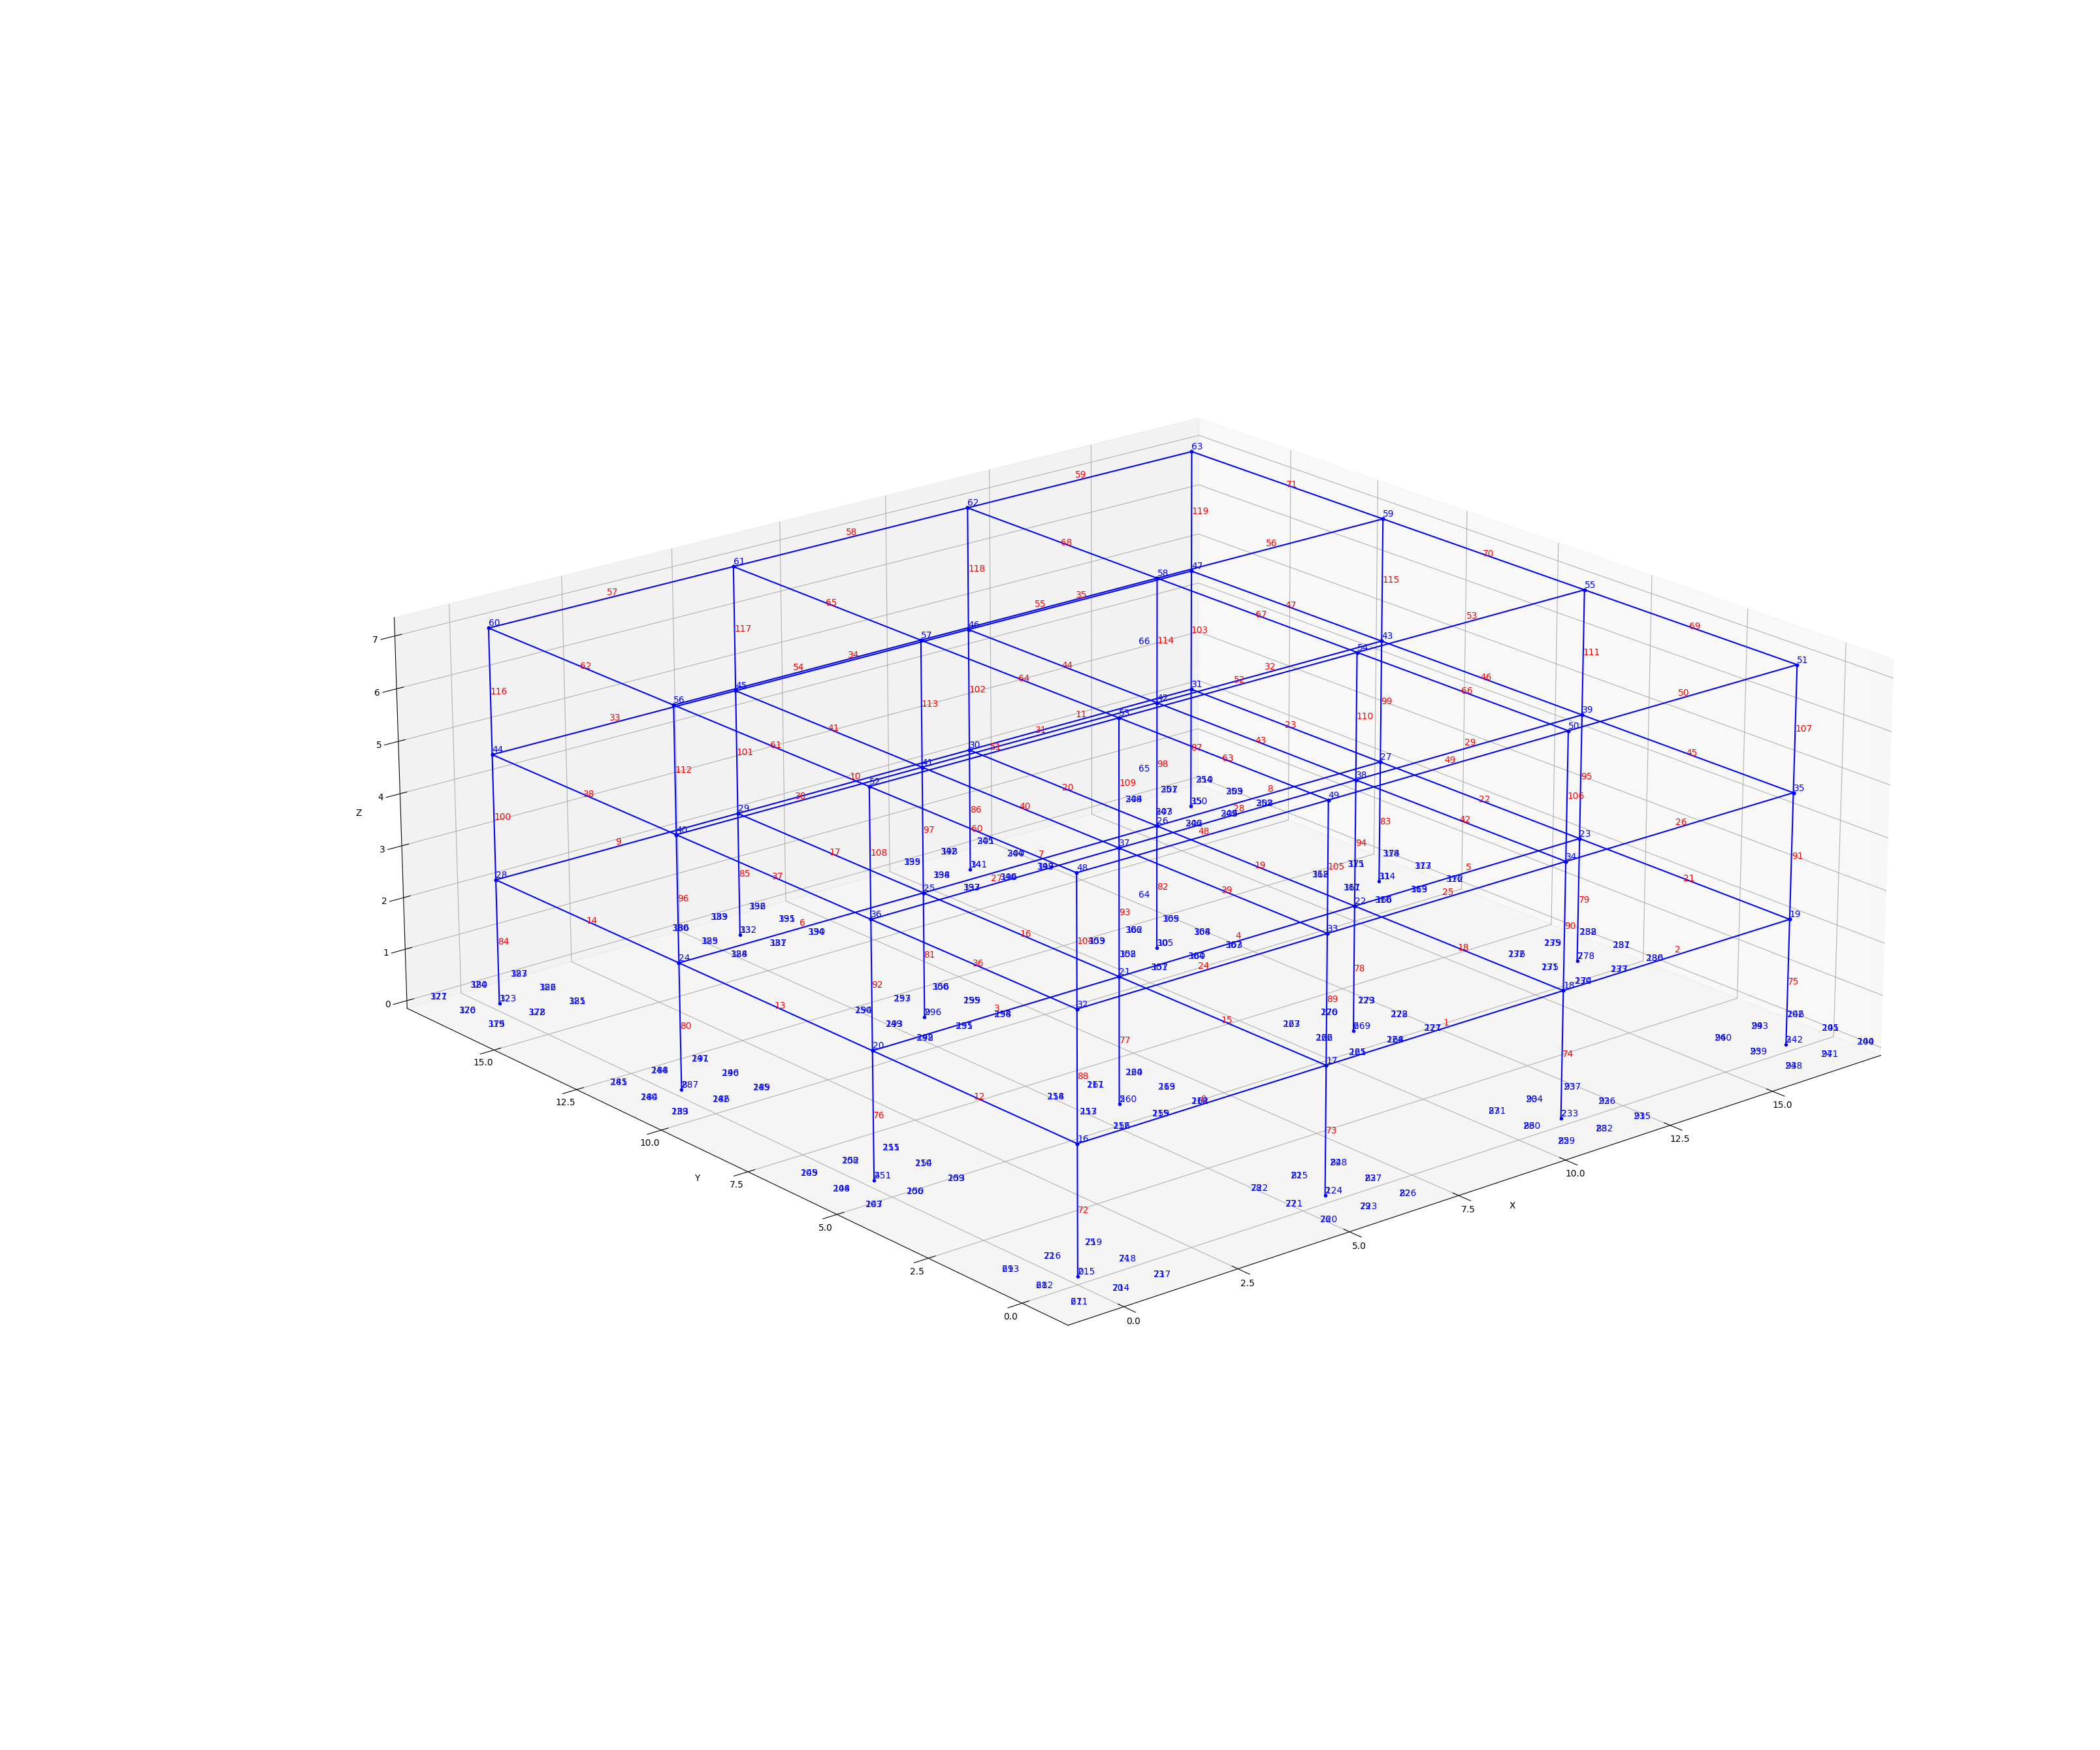

In [51]:
opsv.plot_model(fig_wi_he=(60,50),az_el=(-130,20))

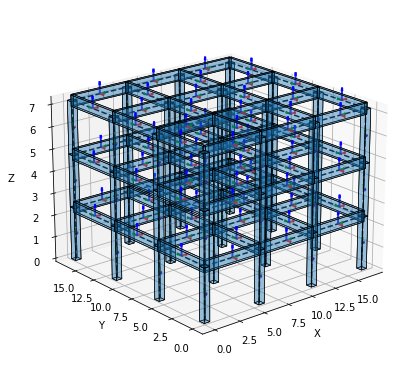

In [136]:
opsv.plot_extruded_shapes_3d(ele_shapes,fig_wi_he=(20,15),az_el=(-130,20))

In [24]:
element('ShellMITC4',120,67,70,0,68,1)
element('ShellMITC4',121,68,0,72,69,1)
element('ShellMITC4',122,70,73,74,0,1)
element('ShellMITC4',123,0,74,75,72,1)
 
element('ShellMITC4',124,76,79,1,77,1)
element('ShellMITC4',125,77,1,81,78,1)
element('ShellMITC4',126,79,82,83,1,1)
element('ShellMITC4',127,1,83,84,81,1)
 
element('ShellMITC4',128,85,88,2,86,1)
element('ShellMITC4',129,86,2,90,87,1)
element('ShellMITC4',130,88,91,92,2,1)
element('ShellMITC4',131,2,92,93,90,1)
 
element('ShellMITC4',132,94,97,3,95,1)
element('ShellMITC4',133,95,3,99,96,1)
element('ShellMITC4',134,97,100,101,3,1)
element('ShellMITC4',135,3,101,102,99,1)

element('ShellMITC4',136,103,106,4,104,1)
element('ShellMITC4',137,104,4,108,105,1)
element('ShellMITC4',138,106,109,110,4,1)
element('ShellMITC4',139,4,110,111,108,1)
 
element('ShellMITC4',140,112,115,5,113,1)
element('ShellMITC4',141,113,5,117,114,1)
element('ShellMITC4',142,115,118,119,5,1)
element('ShellMITC4',143,5,119,120,117,1)
 
element('ShellMITC4',144,121,124,6,122,1)
element('ShellMITC4',145,122,6,126,123,1)
element('ShellMITC4',146,124,127,128,6,1)
element('ShellMITC4',147,6,128,129,126,1)
 
element('ShellMITC4',148,130,133,7,131,1)
element('ShellMITC4',149,131,7,135,132,1)
element('ShellMITC4',150,133,136,137,7,1)
element('ShellMITC4',151,7,137,138,135,1)
    
element('ShellMITC4',152,139,142,8,140,1)
element('ShellMITC4',153,140,8,144,141,1)
element('ShellMITC4',154,142,145,146,8,1)
element('ShellMITC4',155,8,146,147,144,1)
 
element('ShellMITC4',156,148,151,9,149,1)
element('ShellMITC4',157,149,9,153,150,1)
element('ShellMITC4',158,151,154,155,9,1)
element('ShellMITC4',159,9,155,156,153,1)
 
element('ShellMITC4',160,157,160,10,158,1)
element('ShellMITC4',161,158,10,162,159,1)
element('ShellMITC4',162,160,163,164,10,1)
element('ShellMITC4',163,10,164,165,162,1)

element('ShellMITC4',164,166,169,11,167,1)
element('ShellMITC4',165,167,11,171,168,1)
element('ShellMITC4',166,169,172,173,11,1)
element('ShellMITC4',167,11,173,174,171,1)
 
element('ShellMITC4',168,175,178,12,176,1)
element('ShellMITC4',169,176,12,180,177,1)
element('ShellMITC4',170,178,181,182,12,1)
element('ShellMITC4',171,12,182,183,180,1)
 
element('ShellMITC4',172,184,187,13,185,1)
element('ShellMITC4',173,185,13,189,186,1)
element('ShellMITC4',174,187,190,191,13,1)
element('ShellMITC4',175,13,191,192,189,1)
 
element('ShellMITC4',176,193,196,14,194,1)
element('ShellMITC4',177,194,14,198,195,1)
element('ShellMITC4',178,196,199,200,14,1)
element('ShellMITC4',179,14,200,201,198,1)

element('ShellMITC4',180,202,205,15,203,1)
element('ShellMITC4',181,203,15,207,204,1)
element('ShellMITC4',182,205,208,209,15,1)
element('ShellMITC4',183,15,209,210,207,1)

In [25]:
Es1=4000*tonf/m**2
pois1=0.3
h1=3*m

Es2=10000*tonf/m**2
pois2=0.4
h2=4*m

print(Es1)
print(Es2)

39226600.0
98066500.0


In [26]:
ee1=(Es2*(1-pois1**2)*h1)/(Es1*(1-pois2**2)*h2)

C1=1/((h1/Es1)*(1-pois1**2)+(h2/Es2)*(1-pois2**2))
print(C1)
C2=1/(6*(1+pois1)**2)*((Es1*h1/(1+pois1))*(3+3*ee1+ee1**2)+(Es2*h2)/(1+pois2) )
print(C2)

9628522.33676976
145648746.6188505


In [27]:
#uniaxialMaterial('ENT', 8, 5000000)
uniaxialMaterial('Elastic', 8, C1)
uniaxialMaterial('Elastic', 9, C2)
aux=184
for i in range(len(inferior)):
    element('zeroLength', aux, superior[i],inferior[i], '-mat', *[9,9,8], '-dir', *[1,2,3])
    aux=aux+1

No Model_ODB specified, trying to get data from the active model.
3D model


<IPython.core.display.Javascript object>


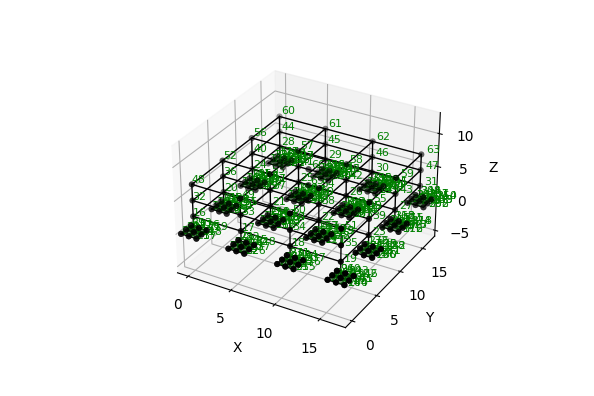

(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:xlabel='X', ylabel='Y'>)

In [28]:
opsplt.plot_model('nodes')
#opsplt.plot_model('nodes','elements')

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


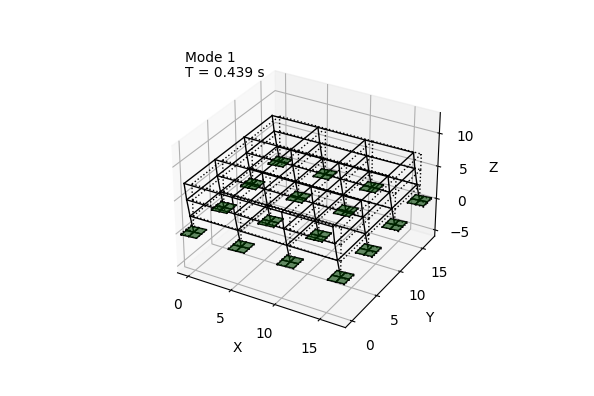

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


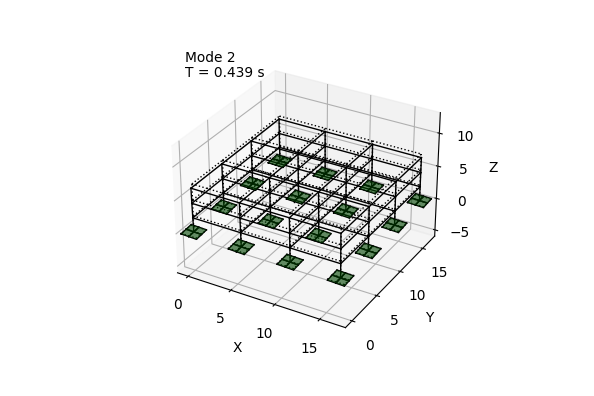

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


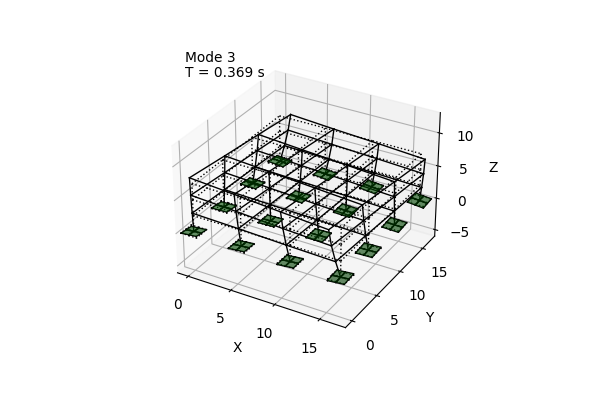

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


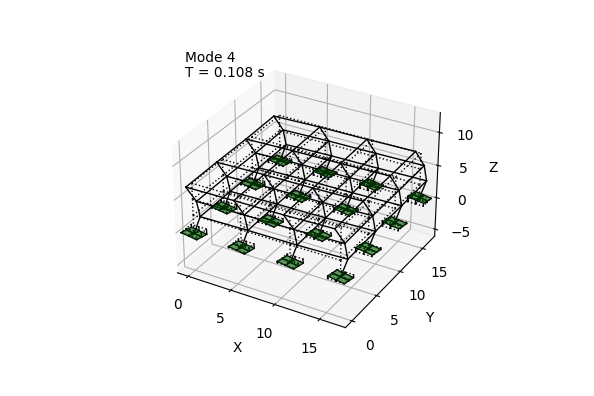

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


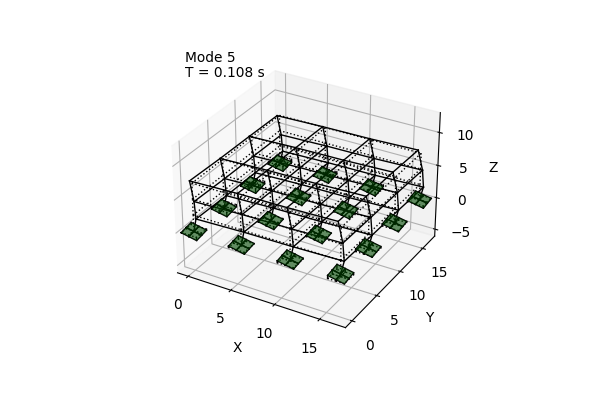

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


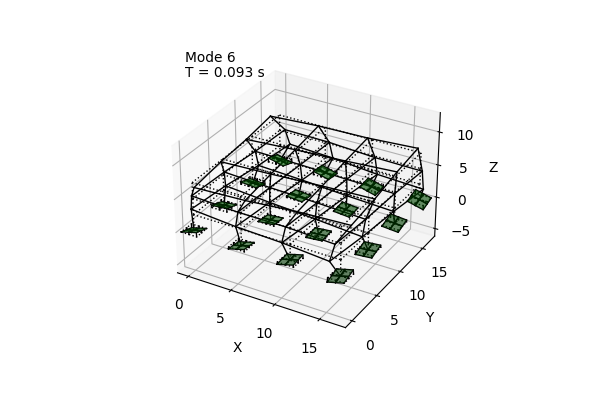

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


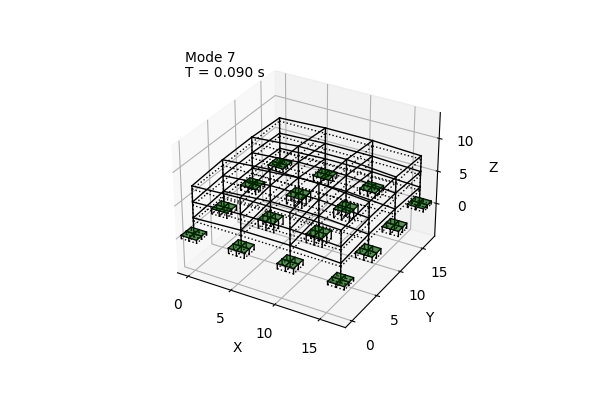

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


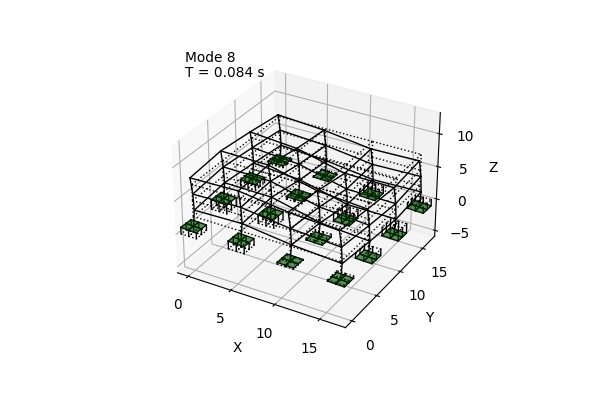

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


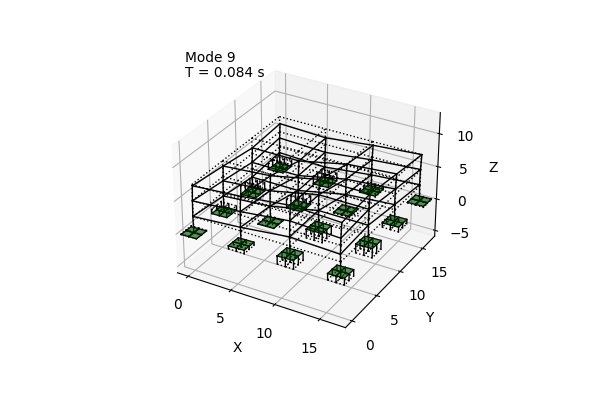

In [29]:
Nmodes=3*(nz-1)

for i in range(Nmodes):
    opsplt.plot_modeshape(i+1,500)

In [30]:
vals=eigen(Nmodes)
Tmodes=np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i]=2*np.pi/vals[i]**0.5
print(Tmodes)

[0.43920212 0.43920212 0.36862525 0.10830296 0.10830296 0.09297146
 0.09025156 0.08378212 0.08378212]


In [31]:
wipeAnalysis()
loadConst('-time', 0.0)

In [32]:
dt = 0.01
accX = np.genfromtxt('Matched_7035.txt')
steps = len(accX)
tFinal = steps*dt
#tFinal = steps*dt

#factor  amplificacion -factor
timeSeries('Path', 2, '-dt', dt, '-values', *accX, '-factor', 9.81)
pattern('UniformExcitation', 2, 1, '-accel', 2)

# damping ratio
damp = 0.05

# # lower frequency
# omega1 = 2 * np.pi / Tmodes[0] # * 0.2
# # upper frequency
# omega2 = 2 * np.pi / Tmodes[3] # * 20
# a0 = 2*damp*omega1*omega2/(omega1 + omega2)
# a1 = 2*damp/(omega1 + omega2)
# print("a0,a1:",a0,a1)
# rayleigh(a0, a1, 0.0, 0.0)

power = 2*np.pi/Tmodes[0]
betaKcomm = 2 * (damp/power)
rayleigh(0.0, 0.0, 0.0, betaKcomm)

constraints('Transformation')
numberer('RCM')
system('UmfPack')
test('NormDispIncr', 1e-8, 100)
algorithm('RaphsonNewton')
integrator('Newmark', 0.5, 0.25)
analysis('Transient')
V=[]
d=[]
d2=[]
d3=[]
t=[]

In [33]:
tests = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 4: 'RelativeNormUnbalance',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
algts = {1:'KrylovNewton', 2: 'SecantNewton' , 4: 'RaphsonNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}

dtA = 0.01
N = int(steps*dt/dtA)
tCurrent = getTime()
k = 0

while tCurrent < tFinal:
    ok = analyze(1, 0.01)
    if ok!=0:
        for i in tests:
            test(tests[i],1.0e-8, 1000)
            for j in algts:
                if j < 4:
                    algorithm(algts[j],'-initial')
                else:
                    algorithm(algts[j])
                print('\n\nIntentando con:',tests[i],algts[j])
                ok = analyze(1, 0.01)
                if ok==0: break
            if ok==0: break

    if ok!=0:
        print('\n'+'='*80)
        print('\n\n\nNo se encontró solución!!! Paso: %i\n\n'%(k))
        break

    currentDisp = nodeDisp(64, 1)
    d.append(currentDisp)
    d2.append(nodeDisp(65, 1))
    d3.append(nodeDisp(66, 1))
    fuerza=0

    for i in range(72,88):
        fuerza=fuerza-eleForce(i)[0]
    V.append(fuerza)
    t.append(tCurrent)
    
    k = k + 1
    tCurrent = getTime()
    if k % int(N/500) == 0:
        print("Paso:",k)
        #opsv2.plot_defo(100)
        #plt.show()

Paso: 13
Paso: 26
Paso: 39
Paso: 52
Paso: 65
Paso: 78
Paso: 91
Paso: 104
Paso: 117
Paso: 130
Paso: 143
Paso: 156
Paso: 169
Paso: 182
Paso: 195
Paso: 208
Paso: 221
Paso: 234
Paso: 247
Paso: 260
Paso: 273
Paso: 286
Paso: 299
Paso: 312
Paso: 325
Paso: 338
Paso: 351
Paso: 364
Paso: 377
Paso: 390
Paso: 403
Paso: 416
Paso: 429
Paso: 442
Paso: 455
Paso: 468
Paso: 481
Paso: 494
Paso: 507
Paso: 520
Paso: 533
Paso: 546
Paso: 559
Paso: 572
Paso: 585
Paso: 598
Paso: 611
Paso: 624
Paso: 637
Paso: 650
Paso: 663
Paso: 676
Paso: 689
Paso: 702
Paso: 715
Paso: 728
Paso: 741
Paso: 754
Paso: 767
Paso: 780
Paso: 793
Paso: 806
Paso: 819
Paso: 832
Paso: 845
Paso: 858
Paso: 871
Paso: 884
Paso: 897
Paso: 910
Paso: 923
Paso: 936
Paso: 949
Paso: 962
Paso: 975
Paso: 988
Paso: 1001
Paso: 1014
Paso: 1027
Paso: 1040
Paso: 1053
Paso: 1066
Paso: 1079
Paso: 1092
Paso: 1105
Paso: 1118
Paso: 1131
Paso: 1144
Paso: 1157
Paso: 1170
Paso: 1183
Paso: 1196
Paso: 1209
Paso: 1222
Paso: 1235
Paso: 1248
Paso: 1261
Paso: 1274
Paso:

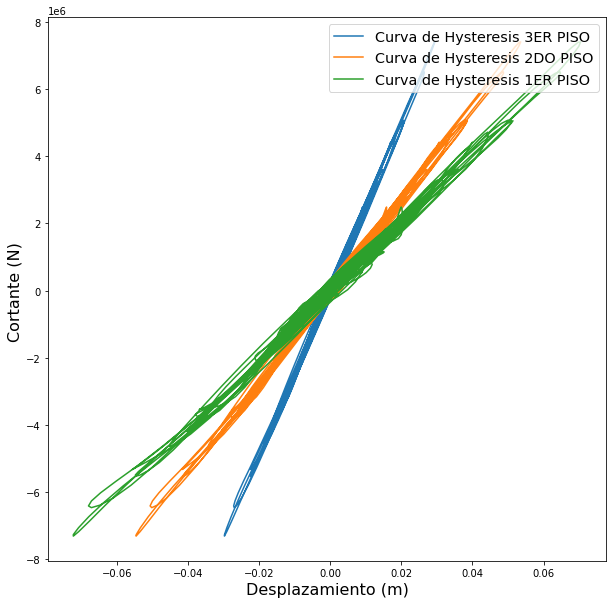

In [34]:
%matplotlib inline
a = 10
b = 10

f1 = plt.figure( figsize = (a,b))
plt.plot(d,V,label='Curva de Hysteresis 3ER PISO')
plt.plot(d2,V,label='Curva de Hysteresis 2DO PISO')
plt.plot(d3,V,label='Curva de Hysteresis 1ER PISO')

plt.legend(loc='upper right', frameon=True, fontsize = 'x-large')
plt.xlabel('Desplazamiento (m)', size = 16)
plt.ylabel('Cortante (N) ', size = 16)

plt.show()

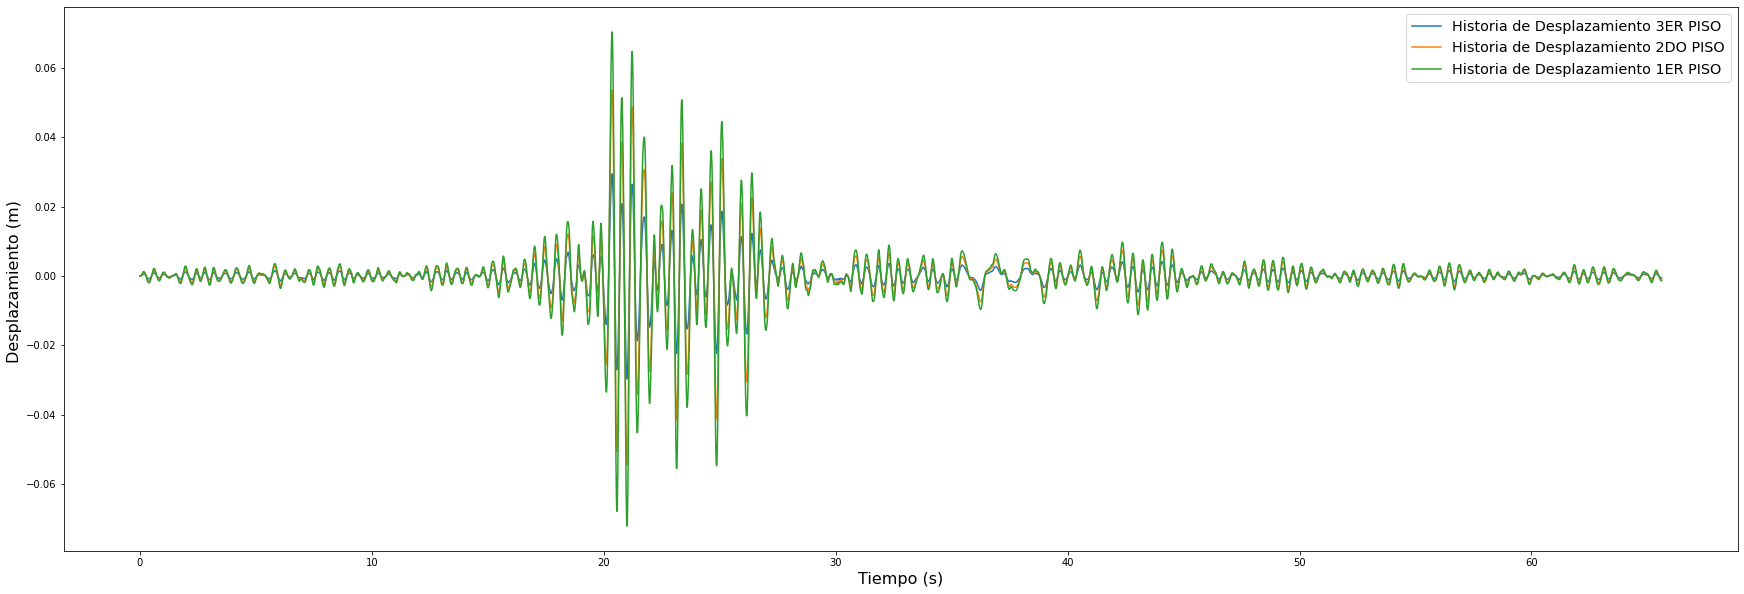

In [35]:
%matplotlib inline
a = 30
b = 10

f1 = plt.figure( figsize = (a,b))
plt.plot(t,d,label='Historia de Desplazamiento 3ER PISO')
plt.plot(t,d2,label='Historia de Desplazamiento 2DO PISO')
plt.plot(t,d3,label='Historia de Desplazamiento 1ER PISO')

plt.legend(loc='upper right', frameon=True, fontsize = 'x-large')
plt.xlabel('Tiempo (s)', size = 16)
plt.ylabel('Desplazamiento (m) ', size = 16)

plt.show()

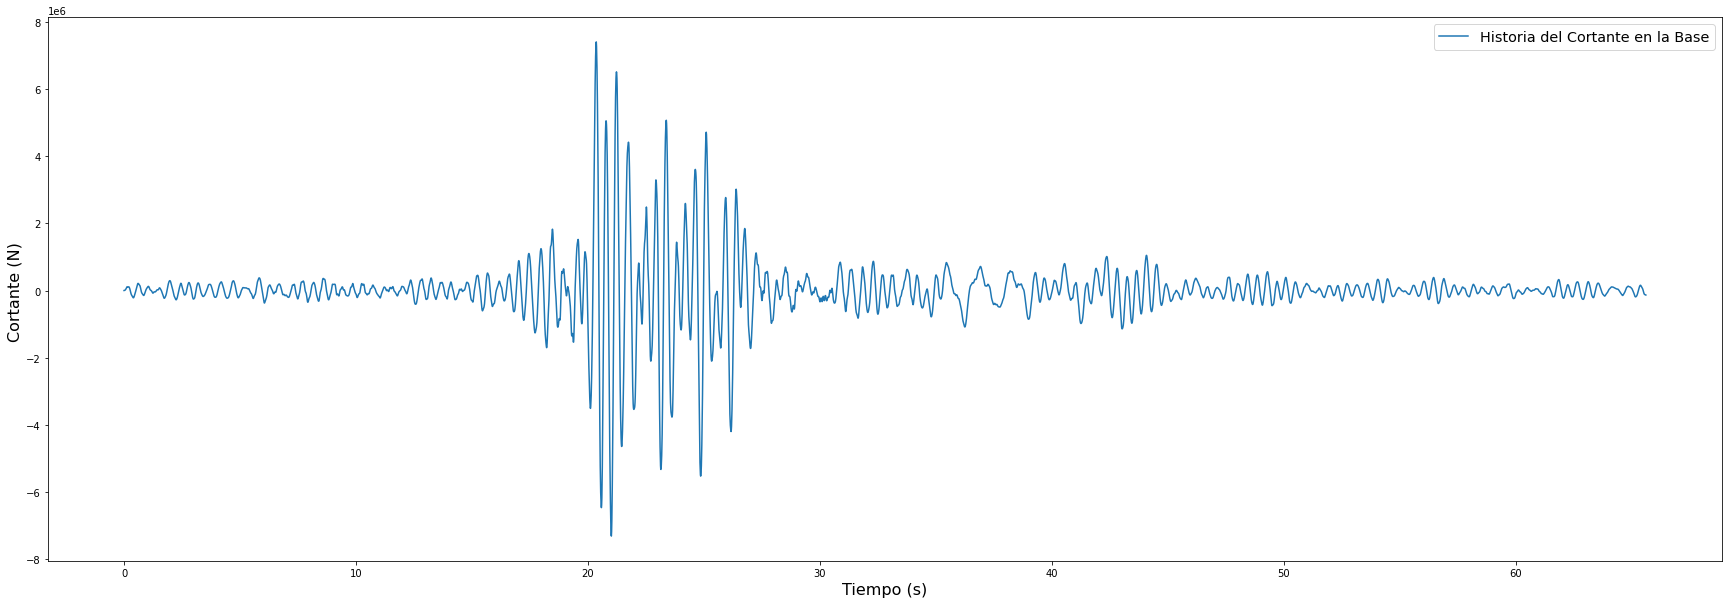

In [36]:
%matplotlib inline
a = 30
b = 10

f1 = plt.figure( figsize = (a,b))
plt.plot(t,V,label='Historia del Cortante en la Base')

plt.legend(loc='upper right', frameon=True, fontsize = 'x-large')
plt.xlabel('Tiempo (s)', size = 16)
plt.ylabel('Cortante (N) ', size = 16)

plt.show()